<center><h5> Data Science For Suppy Chain & Operations </h5></center>

* Après les travaux d'analyse exploratoire des données et de création et préparation des variables, nous nous intéressons à l'implémentation et l'évaluation de modèles **d'apprentissage supervisé**
* A noter que ce Notebook contient quelques exemples de modèles auxquels on s'intéressera. La liste de ces modèles n'est pas du tout exhaustive.

# 0. Rappel - Problématique et jeu de donnée préparés

In [1]:
import numpy as np
import pandas as pd
## On peut choisir le nombre max de lignes/colonnes à voir
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 500)
pd.options.display.float_format = '{:,.2f}'.format

import datetime

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import DateFormatter
import seaborn as sns
sns.set(color_codes = True)
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder,  FunctionTransformer, OrdinalEncoder
#scaler
from sklearn.preprocessing import StandardScaler
#column transformer  and pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
#model selection 
from sklearn.model_selection import cross_val_score, KFold, GroupShuffleSplit
from sklearn.model_selection import GridSearchCV
#linear models
from sklearn.linear_model import LogisticRegressionCV, LassoCV
#ensemble models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
#evaluation 
from sklearn.metrics import mean_squared_error, r2_score

<h5> Charger le fichier de données obtenu de l'autre Notebook </h5>

In [2]:
# Lire les données du dataset
path = 'dataset/data.csv'
df = pd.read_csv(path, parse_dates = ["Date"])

**Rappel de l'objectif** : Prédire les ventes sur une période de $6$  semaines (ou autres) en construisant un modèle de prédiction basé sur une sélection de variables les plus pertinentes pour permettre également d'expliquer l'évolution des ventes. 

**Intérêt métier**:
- Une entreprise qui estime mal ses ventes peut :
    - produire trop et perdre de l'argent en coûts de stockage, (même si elle peut limiter les pertes en procédant à des discounts sur son surplus) 
    - Produire trop peu et dans ce cas là il y a un manque à gagner dû à la demande non satisfaite 
- De plus, un modèle de prévision des ventes peut permettre d'identifier les facteurs qui influent sur les ventes et peut donc permettre d'identifier des leviers d'actions booster les ventes 

Pour la modélisation, on peut penser à différents scénarios ou différentes stratégies, par exemple :
    - Un modèle de séries temporelles
    - Un modèle de Machine learning où l'on créé des features temporelles 
    - etc.
- Dans la suite, nous allons aborder la **deuxième approche** (Machine Learning) à travers différents modèles. La première approche nécessiterait de construire un modèle par store et il se peut que la profondeur historique des données ne soit pas suffisante pour créer des modèles performants.

Lors du cours précédent, nous avons réalisé des premiers travaux d'analyses des données et de préparation d'un data set agrégé. Nous continuerons cette préparation dans ce Notebook avant d'enchainer sur les modèles.

In [3]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Avg_Sales_Per_Customer,Day,Month,Year,CompetitionOpenSince,Promo2Since
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,"1,270.00",9.00,"2,008.00",0,0.00,0.00,0,9.48,31,7,2015,2008-09-01 00:00:00,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,"2,007.00",1,13.00,"2,010.00","Jan,Apr,Jul,Oct",9.70,31,7,2015,2007-11-01 00:00:00,2010-03-29 00:00:00
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,"14,130.00",12.00,"2,006.00",1,14.00,"2,011.00","Jan,Apr,Jul,Oct",10.13,31,7,2015,2006-12-01 00:00:00,2011-04-04 00:00:00
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,"2,009.00",0,0.00,0.00,0,9.34,31,7,2015,2009-09-01 00:00:00,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,"29,910.00",4.00,"2,015.00",0,0.00,0.00,0,8.63,31,7,2015,2015-04-01 00:00:00,0


In [4]:
# Affichage d'informations sur les données 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 24 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1017209 no

In [5]:
# Affichage de la taille du dataset (n_lignes et n_colonnes) 
print("Data's shape : ", df.shape)

Data's shape :  (1017209, 24)


In [6]:
# La fonction housing.isna().sum() de Pandas est utilisée pour détecter et compter 
# les valeurs manquantes en fonction de la colonne 
missing = df.isna().sum() 
print(missing) 

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
PromoInterval                     0
Avg_Sales_Per_Customer       172869
Day                               0
Month                             0
Year                              0
CompetitionOpenSince              0
Promo2Since                       0
dtype: int64


In [7]:
# Autrement
missing = df.isnull().sum().sort_values(ascending=False)
print(missing)

Avg_Sales_Per_Customer       172869
Promo2Since                       0
Assortment                        0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
CompetitionDistance               0
CompetitionOpenSince              0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
PromoInterval                     0
Day                               0
Month                             0
Year                              0
Store                             0
dtype: int64


In [8]:
# Affichage d'informations statistiques sur les données 
# La méthode describe() ignore les valeurs NULL 
df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Avg_Sales_Per_Customer,Day,Month,Year
count,"1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00","844,340.00","1,017,209.00","1,017,209.00","1,017,209.00"
mean,558.43,4.00,"5,773.82",633.15,0.83,0.38,0.18,"5,422.02",4.93,"1,370.17",0.50,11.65,"1,007.01",9.49,15.70,5.85,"2,013.83"
std,321.91,2.00,"3,849.93",464.41,0.38,0.49,0.38,"7,706.92",4.28,935.36,0.50,15.32,"1,005.88",2.20,8.79,3.33,0.78
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,"2,013.00"
25%,280.00,2.00,"3,727.00",405.00,1.00,0.00,0.00,710.00,0.00,0.00,0.00,0.00,0.00,7.90,8.00,3.00,"2,013.00"
50%,558.00,4.00,"5,744.00",609.00,1.00,0.00,0.00,"2,325.00",4.00,"2,006.00",1.00,1.00,"2,009.00",9.25,16.00,6.00,"2,014.00"
75%,838.00,6.00,"7,856.00",837.00,1.00,1.00,0.00,"6,880.00",9.00,"2,011.00",1.00,22.00,"2,012.00",10.90,23.00,8.00,"2,014.00"
max,"1,115.00",7.00,"41,551.00","7,388.00",1.00,1.00,1.00,"75,860.00",12.00,"2,015.00",1.00,50.00,"2,015.00",64.96,31.00,12.00,"2,015.00"


In [9]:
## Quelques fonctions utiles implémentées précédemment
def show_distribution(df, var, n_bins=50, stat="count"):
    """
    Args:
        df : data frame
        var : nom de la colonne de df, pour laquelle on souhaite afficher les graphes de distribution
        n_bins : nombre de bins (barres verticales) dans l'histogramme
        stat : "frequency", "count", "density", or "probability", pour l'histogramme
    Return:
        None
    """
    ## Calcul de statistiques pour les afficher sur l'histogramme en barres verticales
    mean_val = df[var].mean()
    med_val = df[var].median()
    mode_val = df[var].mode()[0]     ## La valeur la plus fréquente
    max_val = df[var].max()

    # Une figure pour 2 subplots : 2 ligne, 1 colonne. Subplot 1 sera un histogramme, subplot 2 un box plot
    fig, ax = plt.subplots(2, 1, figsize = (15,10))

    # Plot histogram   
    sns.histplot(
        data = df,
        x=var, 
        bins=n_bins,
        stat = stat,
        ax = ax[0]
    )

    # Ajouter des lignes verticales pour la moyenne, la mediane, mode, et la valeur max
    ax[0].axvline(x=mean_val, color = 'green', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mode_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'black', linestyle='dashed', linewidth = 2)

    # boxplot   
    sns.boxplot(
        x=df[var], 
        ax= ax[1]
    )
    ax[1].set_xlabel(var + 'Value')

    # Ajouter un titre
    fig.suptitle('Distribution de la variable ' + var)

    # Show the figure
    fig.show()

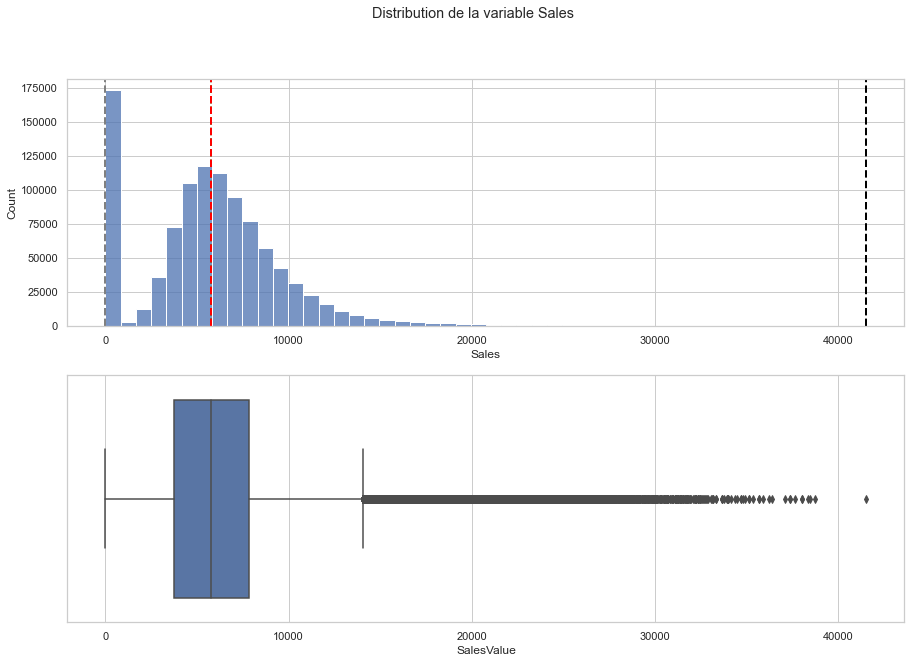

In [10]:
# Visualisation des distributions des variables numériques 
show_distribution(df, 'Sales')

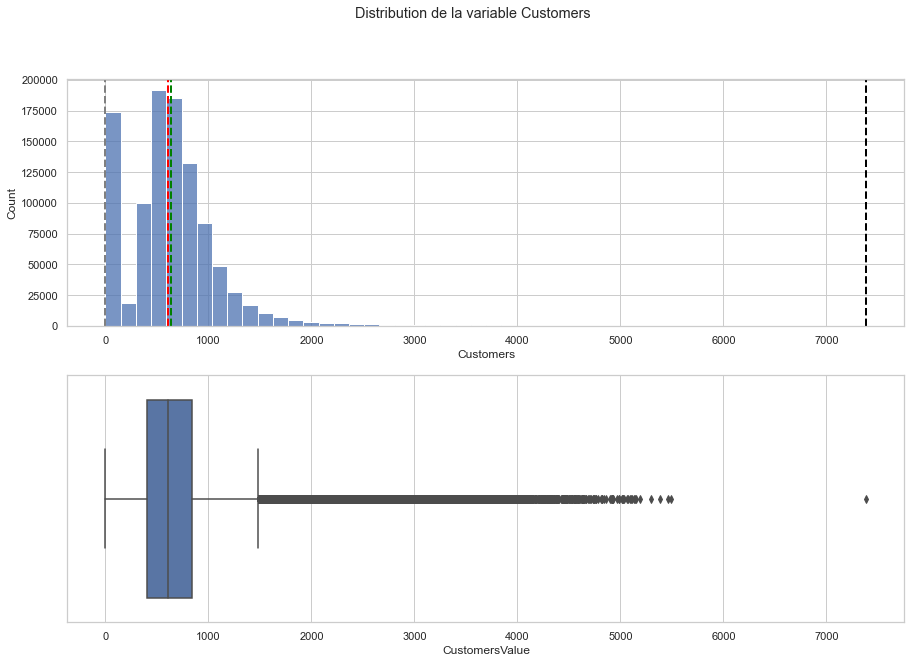

In [11]:
# Visualisation des distributions des variables numériques 
show_distribution(df, 'Customers')

# 1. Suite - transformation du jeu de données

## 1.1 Transformations des variables

In [12]:
# Pour garder une copie de df si on veut refaire des traitements différents
data = df.copy()

<h5>Création de nouvelles variables continues à partir des différentes dates si cela peut être pertinent </h5>

In [13]:
# Nombre de jours/mois depuis la participation à Promo2
# Transformer la colonne Promo2Since en datetime 
# Pour les erreurs (cas Promo2Since = 0), les ignorer => Cela va créer des valeurs NaN, à traiter !
data["Promo2Since"] = pd.to_datetime(data["Promo2Since"], errors='coerce')

In [14]:
# La différence en jours, (peut créer des NaN)
data["DaysSincePromo2"] = (data["Date"] - data["Promo2Since"]).dt.days

In [15]:
# La différence en mois, (peut créer des NaN)
data["MonthsSincePromo2"] = (data["Date"] - data["Promo2Since"])/np.timedelta64(1, 'M')

In [16]:
# Remplacer les NaN dans ces deux nouvelles colonnes
data['DaysSincePromo2'].fillna('0', inplace=True)
data['MonthsSincePromo2'].fillna('0', inplace=True)

In [17]:
# Nombre de jours/mois depuis l'ouverture de la compétition
data["CompetitionOpenSince"] = pd.to_datetime(data["CompetitionOpenSince"], errors='coerce')
# La différence en jours, (peut créer des NaN)
data["DaysSinceCompetition"] = (data["Date"] - data["CompetitionOpenSince"]).dt.days
# La différence en mois, (peut créer des NaN)
data["MonthsSinceCompetition"] = (data["Date"] - data["CompetitionOpenSince"])/np.timedelta64(1, 'M')

In [18]:
## Remplacer les NaN dans ces deux nouvelles colonnes
data['DaysSinceCompetition'].fillna('0', inplace=True)
data['MonthsSinceCompetition'].fillna('0', inplace=True)

In [19]:
data['DaysSincePromo2'] = pd.to_numeric(data['DaysSincePromo2'])
data['MonthsSincePromo2'] = pd.to_numeric(data['MonthsSincePromo2'])
data['DaysSinceCompetition'] = pd.to_numeric(data['DaysSinceCompetition'])
data['MonthsSinceCompetition'] = pd.to_numeric(data['MonthsSinceCompetition'])

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 28 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1017209 no

<h5>One hot encoding des variables catégorielles (ou autres encoding)</h5>

In [21]:
data["StateHoliday"] = data["StateHoliday"].replace({0 : '0'})

In [22]:
# Afficher les variables numériques
numerical_features = data.select_dtypes(include=[np.number]).columns 
print(numerical_features)

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Avg_Sales_Per_Customer', 'Day', 'Month', 'Year',
       'DaysSincePromo2', 'MonthsSincePromo2', 'DaysSinceCompetition',
       'MonthsSinceCompetition'],
      dtype='object')


In [23]:
# Afficher les variables catégorielles
categorical_features = data.select_dtypes(include=[np.object]).columns 
print(categorical_features)

Index(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], dtype='object')


In [24]:
# Une grande partie du prétraitement est le codage 
# On doit représenter chaque élément de données d'une manière compréhensible par l'ordinateur => convertir en langage machine
# Dans de nombreuses branches de l'informatique, en particulier l'apprentissage automatique, 
# One hot encoding est largement utilisé
data = pd.get_dummies(data, columns=['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'])

In [25]:
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Avg_Sales_Per_Customer,Day,Month,Year,CompetitionOpenSince,Promo2Since,DaysSincePromo2,MonthsSincePromo2,DaysSinceCompetition,MonthsSinceCompetition,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,1,5,2015-07-31,5263,555,1,1,1,"1,270.00",9.00,"2,008.00",0,0.00,0.00,9.48,31,7,2015,2008-09-01,NaT,0.00,0.00,"2,524.00",82.93,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0
1,2,5,2015-07-31,6064,625,1,1,1,570.00,11.00,"2,007.00",1,13.00,"2,010.00",9.70,31,7,2015,2007-11-01,2010-03-29,"1,950.00",64.07,"2,829.00",92.95,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
2,3,5,2015-07-31,8314,821,1,1,1,"14,130.00",12.00,"2,006.00",1,14.00,"2,011.00",10.13,31,7,2015,2006-12-01,2011-04-04,"1,579.00",51.88,"3,164.00",103.95,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,4,5,2015-07-31,13995,1498,1,1,1,620.00,9.00,"2,009.00",0,0.00,0.00,9.34,31,7,2015,2009-09-01,NaT,0.00,0.00,"2,159.00",70.93,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0
4,5,5,2015-07-31,4822,559,1,1,1,"29,910.00",4.00,"2,015.00",0,0.00,0.00,8.63,31,7,2015,2015-04-01,NaT,0.00,0.00,121.00,3.98,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0


<h5>D'autres variables à créer ou à transformer (log transform, ...) ?</h5>

<h5>Filtres sur le jeu de données (éliminer les jours de fermeture, les jours avec ventes nulles, ...)</h5>

In [26]:
data = data[(data["Open"]==1) & (data["Sales"]>0)]
## Rajoutez d'autres filtres si cela vous semble pertinent

<h5>Garder que les colonnes utiles</h5>

In [27]:
## Par exemple, les colonnes Open et Customers (leak de la target) ne seront pas gardées
transformed_data = data.drop(['Open', 'Customers', 'CompetitionOpenSince', 'Promo2Since'], axis=1)
transformed_data.head()

,Store,DayOfWeek,Date,Sales,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Avg_Sales_Per_Customer,Day,Month,Year,DaysSincePromo2,MonthsSincePromo2,DaysSinceCompetition,MonthsSinceCompetition,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,1,5,2015-07-31,5263,1,1,"1,270.00",9.00,"2,008.00",0,0.00,0.00,9.48,31,7,2015,0.00,0.00,"2,524.00",82.93,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0
1,2,5,2015-07-31,6064,1,1,570.00,11.00,"2,007.00",1,13.00,"2,010.00",9.70,31,7,2015,"1,950.00",64.07,"2,829.00",92.95,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
2,3,5,2015-07-31,8314,1,1,"14,130.00",12.00,"2,006.00",1,14.00,"2,011.00",10.13,31,7,2015,"1,579.00",51.88,"3,164.00",103.95,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,4,5,2015-07-31,13995,1,1,620.00,9.00,"2,009.00",0,0.00,0.00,9.34,31,7,2015,0.00,0.00,"2,159.00",70.93,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0
4,5,5,2015-07-31,4822,1,1,"29,910.00",4.00,"2,015.00",0,0.00,0.00,8.63,31,7,2015,0.00,0.00,121.00,3.98,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0


## 1.2 Stratégie de validation et split du jeu de données

<h5>Quelle(s) différentes métrique(s) peut-on utiliser ?</h5>
<br> La documentation sklearn contient la liste des métriques implémentées et leurs explications : <a href="https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics"> **Lien ICI** </a><br>

- ...

<h5>Pour la suite, on vous demandera d'inclure le <u>RMSE</u> dans vos résultats.</h5>

<h5>Comment réaliser la validation des modèles entrainés ? (split temporel, split aléatoire, ...)</h5>
<br> Proposition : un split temporel - entrainer sur les données du 01/01/2013 au 31/12/2014 et évaluer sur les données à partir du 01/01/2015

In [28]:
## Séparation train/test (nh'ésitez pas à tester plusieurs splits)
train_date = (transformed_data['Date'] >= '2013-01-01') & (transformed_data['Date'] <= '2017-12-31')
test_date = (transformed_data['Date'] >= '2015-01-01')
data_train = transformed_data[train_date]
data_test = transformed_data[test_date]

In [29]:
X_train = data_train.drop(['Sales','Date'], axis=1).values
y_train = data_train.Sales.values
X_test = data_test.drop(['Sales','Date'], axis=1).values
y_test = data_test.Sales.values

In [30]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)
print("The training dataset has {} examples and {} features.".format(X_train.shape[0], X_train.shape[1]))
print("The testing dataset has {} examples and {} features.".format(X_test.shape[0], X_test.shape[1]))

X_train shape : (844338, 33)
y_train shape : (844338,)
X_test shape : (196029, 33)
y_test shape : (196029,)
The training dataset has 844338 examples and 33 features.
The testing dataset has 196029 examples and 33 features.


<h5>Normalisation des données</h5>

Essayer différentes normalisations (standard scaler, etc.) si ça vous semble pertinents.
<br> La documentation sklearn contient la liste des métriques implémentées et leurs explications : <a href="https://scikit-learn.org/stable/modules/preprocessing.html">**Lien ICI**</a><br>
**Remarque 1** : la méthode fit() pour la normalisation doit être appliquée sur le jeu de train uniquement. La même transformation sera appliquée (fit_transform()) ensuite sur les jeux de train et test. <br>
**Remarque 2** : vous pouvez évaluer un même modèle avant / après normalisation pour comparer la résultats.

In [31]:
from sklearn.preprocessing import StandardScaler
feature_scaler = StandardScaler()
feature_scaler = feature_scaler.fit(X_train)
X_training = feature_scaler.fit_transform(X_train)
X_testing = feature_scaler.transform(X_test)

# 2. Régression Linéaire

Pour les différents modèles, la documentation sklearn détaille les différentes fonctions et méthodes disponibles que vous pourrez utiliser. Vous pourrez également vous baser sur le Notebook du cours 0, partie 3. (Introduction Python).
<br> Documentation SKLearn Régression Linéaire : <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">**Lien ICI**</a><br>

### Evaluation du modèle avant normalisation

In [32]:
# Commençons par le modèle de base 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score  
# Création d'une instance (le modèle lin_reg) par le constructeur LinearRegression()  
lin_reg = LinearRegression() 
# Apprentissage du modèle par la méthode fit() : Il s'agit d'une approche d'apprentissage 
# supervisée puisqu'on utilise lin_reg.fit(X_train, y_train) 
lin_reg.fit(X_train, y_train) 
# Prédiction des les données d'apprentissage X_train par la méthode .predict() 
y_pred = lin_reg.predict(X_train) 
# Evaluation de la prédiction obtenue avec les deux métriques R2 et RMSE 
rmse = np.sqrt(mean_squared_error(y_train, y_pred)) 
r2 = r2_score(y_train, y_pred) 
print("Training: R2=", r2, " et RMSE=", rmse) 
# Prédiction sur les données de test X_test par la méthode .predict() 
y_pred = lin_reg.predict(X_test) 
# Evaluation de la prédiction obtenue avec les deux métriques R2 et RMSE 
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
r2 = r2_score(y_test, y_pred) 
print("Testing: R2=", r2, " et RMSE=", rmse) 

Training: R2= 0.2514710548155372  et RMSE= 2685.344087334176
Testing: R2= 0.2625513967847568  et RMSE= 2605.5506203394425


### Evaluation du modèle après normalisation

In [33]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score  
lin_reg = LinearRegression() 
lin_reg.fit(X_training, y_train)  
y_pred = lin_reg.predict(X_training) 
rmse = np.sqrt(mean_squared_error(y_train, y_pred)) 
r2 = r2_score(y_train, y_pred) 
print("Training: R2=", r2, " et RMSE=", rmse) 
y_pred = lin_reg.predict(X_testing) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
r2 = r2_score(y_test, y_pred) 
print("Testing: R2=", r2, " et RMSE=", rmse) 

Training: R2= 0.2514660453394555  et RMSE= 2685.35307305514
Testing: R2= 0.2626241184660568  et RMSE= 2605.422147187209


# 3. Decision Tree

*Même démarche pour la régression linéaire...*
<br> Documentation Decision Tree : <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html">**Lien ICI**</a><br>

In [34]:
from sklearn.tree import DecisionTreeRegressor 
# Création d'une instance dt_reg par le constructeur DecisionTreeRegressor() 
dt_reg = DecisionTreeRegressor() 
# Apprentissage du modèle dt_reg par fit 
dt_reg.fit(X_train, y_train) 
# Pédiction sur X_train par la méthode predict() 
y_pred = dt_reg.predict(X_train) 
# Evaluation en calculant les métriques R2 et RMSE 
rmse = np.sqrt(mean_squared_error(y_train, y_pred)) 
r2 = r2_score(y_train, y_pred) 
print("Training: R2=", r2, " et RMSE=", rmse) 
# Prédiction sur X_test par la méthode predict() 
y_pred = dt_reg.predict(X_test) 
# Evaluation en calculant les métriques R2 et RMSE 
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
r2 = r2_score(y_test, y_pred) 
print("Testing: R2=", r2, " et RMSE=", rmse)

Training: R2= 1.0  et RMSE= 0.0
Testing: R2= 1.0  et RMSE= 0.0


### Conclusion : 
> Pour DecisionTreeRegressor, plus les valeurs de RMSE et de R-carré (R2) sont proches de 0 et 1, respectivement, plus les résultats du modèle seront précis.

> Une valeur RMSE >= 0,5 et une valeur R2 =< 0.5 reflète la faible capacité du modèle à prédire avec précision les données.

> Dans notre cas notre modèle est bien précis.

# 4. Random Forest

<br> Documentation Random Forest : <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html">**Lien ICI**</a><br>

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
# Création d'une instance par le constructeur RandomForestRegressor() 
rf_reg = RandomForestRegressor() 
# Apprentissage du modèle rf_reg par la méthode fit() 
rf_reg.fit(X_train, y_train) 
# Prédiction sur X_train par la méthode predict() 
y_pred = rf_reg.predict(X_train) 
# Evaluation e calculant R2 et RMSE 
rmse = np.sqrt(mean_squared_error(y_train, y_pred)) 
r2 = r2_score(y_train, y_pred) 
print("Training: R2=", r2, " et RMSE=", rmse) 
# Prédiction sur X_test par la méthode predict() 
y_pred = rf_reg.predict(X_test) 
#Evaluation e calculant R2 et RMSE 
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
r2 = r2_score(y_test, y_pred) 
print("Testing: R2=", r2, " et RMSE=", rmse) 

# 5. [Optional] Autres modèles à explorer

- Si vous le souhaitez, vous pouvez explorer d'autres modèles : XGBoost, SVM, ...
- A part les modèles deep learning, vous trouverez des implémentations des modèles ML dans sklearn

# Conclusions

- Présentez et comparer les différents résultats obtenus avec les différents modèles. Quel modèle vous retenez et pourquoi ?
- Interprétabilité métier des résultats

In [35]:
# Les modèles testés from sklearn.pipeline 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
 
print(LinearRegression().get_params()) 
print(DecisionTreeRegressor().get_params()) 
print(RandomForestRegressor().get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


In [36]:
# K-fold cross-validation et GridSearchCV 
pipelines = [] 
params = [] 
names = [] 
 
# Ajouter LinearRegression 
pipelines.append(Pipeline([('clf', LinearRegression())])) 
## LinearRegressionRegressor 
params.append({'clf__normalize':[True]}) 
names.append('LinearRegression') 
# Ajouter DecisionTreeRegressor 
pipelines.append(Pipeline([('clf', DecisionTreeRegressor())])) 
## DecisionTreeRegressor 
params.append({'clf__max_depth':np.linspace(5, 15, 5)}) 
names.append('DecisionTreeRegressor') 
# Ajouter RandomForestRegressor 
pipelines.append(Pipeline([('clf', RandomForestRegressor())])) 
## RandomForestRegressor 
params.append({'clf__n_estimators': [50,100,200]}) 
names.append('RandomForestRegressor')

In [37]:
# L'enraînement avec cross-validation 
# n_jobs = -1 signifie que le calcul sera distribué sur tous les CPU de l'ordinateur 
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score 
def model(pipeline, parameters, name, X, y):        
    cv = KFold(n_splits=3, shuffle=True, random_state=32)    
    grid_obj = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=cv, scoring='r2', n_jobs=-1)    
    grid_obj.fit(X,y)      
    print(name, 'R2:', grid_obj.best_score_)    
    estimator = grid_obj.best_estimator_    
    estimator.fit(X,y) # Training sur tout training data   
    return estimator   
estimators = [] 
for i in range(len(pipelines)):
    estimators.append(model(pipelines[i], params[i], names[i], X_train, y_train))

LinearRegression R2: 0.25138422362072194
DecisionTreeRegressor R2: 0.7145989671276786
